### **Import library**

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, DepthwiseConv1D, Conv1D, Dropout, GRU, BatchNormalization, Activation
from tensorflow.keras.losses import MSE, MAPE, MAE
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

### **Config**

In [377]:
path = r"/kaggle/input/gefcom2014-dataset/GEFCom2014 Data/GEFCom2014-S_V2/Solar/Task 15/predictors15.csv"
result = "/kaggle/working/"

batch_size = 32
windown_size = 144
predict_horizon = 144
epoch = 100

### **Process Data**

In [378]:
farm_df = pd.read_csv(path)
farm_df = farm_df[farm_df["ZONEID"]==1]

farm_df.head(3)

,ZONEID,TIMESTAMP,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228,POWER
0,1,20120401 01:00,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000,0.754103
1,1,20120401 02:00,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000,0.555000
2,1,20120401 03:00,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341,0.438397


In [379]:
len(farm_df)

19704

In [380]:
farm_df.describe()

,ZONEID,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228,POWER
count,19704.0,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,1.970400e+04,1.970400e+04,1.970400e+04,19704.000000,19704.000000
mean,1.0,0.039979,0.016466,94728.857310,68.458167,0.433079,0.854414,-0.331767,285.724220,1.230162e+07,1.394561e+07,1.435812e+07,0.000977,0.169321
std,0.0,0.117575,0.051613,603.340900,20.056606,0.401259,2.792177,1.876658,7.128859,6.660757e+06,7.789642e+06,7.074539e+06,0.003358,0.258784
min,1.0,0.000000,0.000000,92582.125000,6.348233,0.000000,-8.908603,-7.636124,270.266357,1.488887e+05,8.659728e+05,6.577261e+05,0.000000,0.000000
25%,1.0,0.000000,0.000000,94334.953125,53.740662,0.010712,-1.042297,-1.526728,280.390198,7.318301e+06,7.383988e+06,9.236506e+06,0.000000,0.000000
50%,1.0,0.002682,0.000098,94739.468750,71.707939,0.340118,0.630157,-0.500415,284.986450,1.100410e+07,1.382263e+07,1.310932e+07,0.000000,0.002564
75%,1.0,0.032245,0.006822,95150.312500,85.637417,0.885901,2.481762,0.839595,290.315979,1.727397e+07,2.016933e+07,1.976043e+07,0.000222,0.273317
max,1.0,3.184086,0.749807,96317.125000,101.790909,1.000007,13.056718,8.979910,310.458496,3.435448e+07,3.467366e+07,3.720136e+07,0.047260,0.916154


#### **EDA**

In [381]:
# import matplotlib.pyplot as plt

# # Loại bỏ các cột không cần thiết
# plot_data = farm_df.drop(["ZONEID", "TIMESTAMP", "POWER"], axis=1)

# # Xác định số lượng biến
# num_plots = len(plot_data.columns)

# # Xác định số hàng và cột hợp lý (4 hàng, 3 cột)
# rows, cols = 3, 4

# # Tạo figure với subplots
# fig, axes = plt.subplots(rows, cols, figsize=(13, 10))
# fig.suptitle("Biểu đồ Box Plot cho Farm1", fontsize=16)

# # Chuyển mảng 2D thành 1D để tránh lỗi index
# axes = axes.flatten()

# # Vẽ box plot trên từng subplot
# for idx, col in enumerate(plot_data.columns):
#     ax = axes[idx]  # Lấy subplot từ danh sách
#     ax.boxplot(plot_data[col].values)
#     ax.set_title(col)
#     ax.set_ylabel("Giá trị")

# # Ẩn subplot thừa nếu số biến < 12
# for idx in range(num_plots, len(axes)):
#     fig.delaxes(axes[idx])

# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Điều chỉnh bố cục tránh chồng tiêu đề
# plt.show()
# # VAR175 VAR164 VAR157

In [382]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Loại bỏ các cột không cần thiết
# plot_data = farm_df.drop(["ZONEID", "TIMESTAMP"], axis=1)

# # Xác định số lượng biến
# num_plots = len(plot_data.columns)

# # Xác định số hàng và số cột (4 hàng, 3 cột)
# rows, cols = 4, 4

# # Tạo figure với subplots
# fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
# fig.suptitle("Biểu đồ Phân phối Dữ liệu", fontsize=16)

# # Chuyển mảng subplot thành danh sách 1D
# axes = axes.flatten()

# # Vẽ histogram + KDE (biểu đồ phân phối) cho từng biến
# for idx, col in enumerate(plot_data.columns):
#     ax = axes[idx]
#     sns.histplot(plot_data[col], bins=30, kde=True, ax=ax, color="blue")
#     ax.set_title(col)
#     ax.set_xlabel("Giá trị")
#     ax.set_ylabel("Tần suất")

# # Ẩn subplot trống nếu số biến < 12
# for idx in range(num_plots, len(axes)):
#     fig.delaxes(axes[idx])

# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Điều chỉnh layout tránh chồng tiêu đề
# plt.show()

In [383]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plot_data = farm_df.drop(["ZONEID", "TIMESTAMP"], axis=1)
# correlation_matrix = plot_data.corr()

# # Vẽ heatmap cho ma trận tương quan
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# plt.title("Heatmap Ma trận tương quan")
# plt.show()

In [384]:
farm_df1 = farm_df.copy()
data = farm_df1.drop(["ZONEID", "VAR178"], axis= 1)
# data = farm_df1.drop(["ZONEID"], axis= 1)

#### **Chuẩn bị dữ liệu để train**

In [385]:
### chuyển cột TIMESTAMP về dạng thời gian
def conv_datetime(data: pd.DataFrame):
    data["TIMESTAMP"] = pd.to_datetime(data["TIMESTAMP"])
    data['Year'] = data['TIMESTAMP'].dt.year  # Năm
    data['Month'] = data['TIMESTAMP'].dt.month  # Tháng
    data['Day'] = data['TIMESTAMP'].dt.day      # Ngày
    data['Hour'] = data['TIMESTAMP'].dt.hour    # Giờ
    return

conv_datetime(data)
power = data["POWER"]
data = data.drop(["POWER"], axis=1)
data["POWER"] = power
data

,TIMESTAMP,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR228,Year,Month,Day,Hour,POWER
0,2012-04-01 01:00:00,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,0.000000,2012,4,1,1,0.754103
1,2012-04-01 02:00:00,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,0.000000,2012,4,1,2,0.555000
2,2012-04-01 03:00:00,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,0.001341,2012,4,1,3,0.438397
3,2012-04-01 04:00:00,0.057167,0.110645,94704.0625,67.775284,0.965866,3.106102,-1.446051,293.261475,9860520.0,4921504.0,0.002501,2012,4,1,4,0.145449
4,2012-04-01 05:00:00,0.051027,0.189560,94675.0000,70.172989,0.944669,2.601146,-1.904493,292.732910,11143097.0,6254380.0,0.003331,2012,4,1,5,0.111987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,2014-06-30 20:00:00,0.000668,0.000000,95168.9375,88.063522,0.030334,2.378217,-0.451427,276.305176,8284894.0,19331312.0,0.000000,2014,6,30,20,0.000000
19700,2014-06-30 21:00:00,0.000488,0.000000,95211.0000,90.338135,0.008423,2.118501,-0.930668,275.912353,8284894.0,20258640.0,0.000000,2014,6,30,21,0.000064
19701,2014-06-30 22:00:00,0.000877,0.000000,95257.4375,90.855988,0.116913,2.239975,-1.051635,276.846680,8365469.0,21171920.0,0.000000,2014,6,30,22,0.013846
19702,2014-06-30 23:00:00,0.003975,0.000023,95320.5625,83.122147,0.317291,3.114827,-0.570367,279.001709,8937086.0,22126240.0,0.000000,2014,6,30,23,0.043718


In [386]:
### Set index cột Timestamp
def set_id(data:pd.DataFrame):
    data.set_index(["TIMESTAMP"], inplace= True)
    return
set_id(data)

In [387]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# correlation_matrix = data.corr()

# # Vẽ heatmap cho ma trận tương quan
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# plt.title("Heatmap Ma trận tương quan")
# plt.show()

In [388]:
### Viết hàm tạo cửa sổ trượt dữ liệu dạng chuỗi

def create_sequences(x, y, window_size, prediction_horizon):
    X, Y = [], []  # Khởi tạo hai danh sách rỗng để lưu trữ các chuỗi đầu vào (X) và chuỗi đầu ra (y)

    # Vòng lặp qua toàn bộ dữ liệu, từ vị trí 0 cho đến vị trí mà vẫn có thể lấy đủ một cửa sổ thời gian và một chuỗi dự đoán
    for i in range(len(x) - window_size - prediction_horizon + 1):
        # Lấy một cửa sổ thời gian (window) từ dữ liệu với kích thước window_size
        # Tại mỗi bước của vòng lặp, cửa sổ này bao gồm tất cả các đặc trưng (features)
        X.append(x[i:(i + window_size), :])

        # Lấy chuỗi giá trị mục tiêu (target) tương ứng với cửa sổ thời gian đã chọn
        # Chuỗi này gồm prediction_horizon bước thời gian, chỉ lấy cột cuối cùng (cột target)
        Y.append(y[(i + window_size):(i + window_size + prediction_horizon)])

    # Chuyển đổi danh sách X và y thành mảng numpy và trả về
    return np.array(X), np.array(Y)

def split_data(X, y, train_ratio=0.8, val_ratio=0.1):
    # Xác định kích thước các tập dữ liệu
    total_samples = len(X)
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)

    # Chia dữ liệu liên tục
    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]

    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [389]:
### chuẩn hóa dữ liệu từng farm
data1 = data.copy()

import numpy as np
import pandas as pd

    
features = ['VAR78', 'VAR79', 'VAR134', 'VAR157', 'VAR164', 'VAR165', 'VAR166', 'VAR167', 'VAR169', 'VAR175', 'VAR228', "Year", "Month", "Day", "Hour"]
# features = ['VAR78', 'VAR79', 'VAR134', 'VAR157', 'VAR164', 'VAR165', 'VAR166', 'VAR167', 'VAR169', 'VAR175', 'VAR178', 'VAR228']
target = 'POWER'

# data1 = log_scaler(data1)
ft = StandardScaler()
data1[features] = ft.fit_transform(data1[features])
# data1 = log_scaler(data1)
data_scaled = data1.values

In [390]:
### chuẩn bị dữ liệu cho farm1
x, y = data_scaled, data_scaled[:,-1]
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)

x_train, y_train = create_sequences(x_train, y_train, windown_size, predict_horizon)
x_val, y_val = create_sequences(x_val, y_val, windown_size, predict_horizon)
x_test, y_test = create_sequences(x_test, y_test, windown_size, predict_horizon)

print(f"train_Farm1: {x_train.shape}, {y_train.shape}")
print("=================================================")
print(f"val_Farm1: {x_val.shape}, {y_val.shape}")
print("=================================================")
print(f"test_Farm1: {x_test.shape}, {y_test.shape}")

train_Farm1: (15476, 144, 16), (15476, 144)
val_Farm1: (1683, 144, 16), (1683, 144)
test_Farm1: (1684, 144, 16), (1684, 144)


In [391]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### **Built Model**

In [400]:
### xây dựng model TCN-GRU
nums_fillter = x_test.shape[2] # tương ứng với 12 feature của dữ liệu
input_shapes = (windown_size, nums_fillter)
models = Sequential([
    # Bit_wise block 1
    Conv1D(filters= nums_fillter, kernel_size=1, padding="causal", input_shape=input_shapes),
    BatchNormalization(),
    Activation("relu"),
    DepthwiseConv1D(kernel_size=3, dilation_rate=2, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Block 2
    Conv1D(filters= nums_fillter, kernel_size=1, padding="causal"),
    BatchNormalization(),
    Activation("relu"),
    DepthwiseConv1D(kernel_size=3, dilation_rate=4, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Block 3
    Conv1D(filters= nums_fillter, kernel_size=1, padding="causal"),
    BatchNormalization(),
    Activation("relu"),
    DepthwiseConv1D(kernel_size=3, dilation_rate=8, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Block 4
    Conv1D(filters= nums_fillter, kernel_size=1, padding="causal"),
    BatchNormalization(),
    Activation("relu"),
    DepthwiseConv1D(kernel_size=3, dilation_rate=16, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Block 5
    Conv1D(filters= nums_fillter, kernel_size=1, padding="causal"),
    BatchNormalization(),
    Activation("relu"),
    DepthwiseConv1D(kernel_size=3, dilation_rate=32, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    GRU(64),
    Dense(predict_horizon)
])
models.compile(loss='MAE', optimizer='Adam', metrics=['mse'])
models.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_70 (Conv1D)              │ (None, 144, 16)        │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_140 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_70             │ (None, 144, 16)        │            64 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_141 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 144, 16)        │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_142         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_142 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_71             │ (None, 144, 16)        │            64 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_143         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_143 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 144, 16)        │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_144 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_72             │ (None, 144, 16)        │            64 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_145         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_145 (Activation)     │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 144, 16)        │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_146         │ (None, 144, 16)        │            64 │
│ (BatchNormalization)            │                        │             

 Total params: 27,424 (107.12 KB)

 Trainable params: 27,104 (105.88 KB)

 Non-trainable params: 320 (1.25 KB)

### **Trainning Model**

In [ ]:
checkpoint = ModelCheckpoint(result + "TCN_GRU_model1.keras", save_best_only=True)

models.fit(train, validation_data=val, epochs=30, callbacks=[checkpoint], verbose=1)

Epoch 1/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.1477 - mse: 0.0596 - val_loss: 0.0926 - val_mse: 0.0246
Epoch 2/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0691 - mse: 0.0154 - val_loss: 0.0855 - val_mse: 0.0259
Epoch 3/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0638 - mse: 0.0149 - val_loss: 0.0835 - val_mse: 0.0256
Epoch 4/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0623 - mse: 0.0149 - val_loss: 0.0823 - val_mse: 0.0257
Epoch 5/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0616 - mse: 0.0149 - val_loss: 0.0815 - val_mse: 0.0259
Epoch 6/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0613 - mse: 0.0151 - val_loss: 0.0809 - val_mse: 0.0260
Epoch 7/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0612 - mse: 0.0152 - val_loss: 0.0804 - val_mse: 0.0260
Epoch 8/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0611 - mse: 0.0153 - val_loss: 0.0799 - val_mse: 0.0260
Epoch 9/30
484/484 ━━━━━━━━━━━━━━━━━━━━ 

### **Evaluate Model**

In [408]:
from tensorflow.keras.models import load_model

# Đường dẫn tới mô hình của bạn
model_path = result + "TCN_GRU_model1.keras"

# Tải mô hình
model = load_model(model_path)

# Kiểm tra mô hình đã được tải thành công
print("Model loaded successfully!")


Model loaded successfully!


In [409]:
y_pred = model.predict(x_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [425]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Giả sử y_test1 là giá trị thực tế và y_pred1 là dự đoán của mô hình

# Tính toán các metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

SyntaxError: incomplete input (3945085817.py, line 15)

In [411]:
len(y_pred)

1684

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


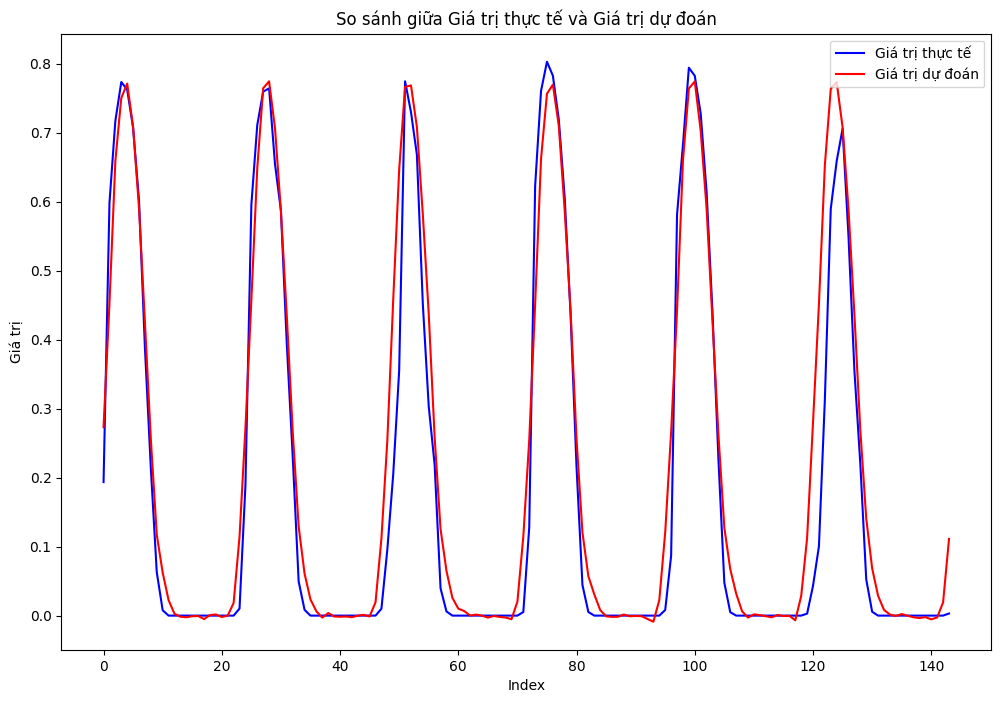

In [413]:
ypred = model.predict(x_test)

# Vẽ biểu đồ line
plt.figure(figsize=(12, 8))
plt.plot(y_test[0], label='Giá trị thực tế', color='blue')
plt.plot(ypred[0], label='Giá trị dự đoán', color='red')
plt.xlabel('Index')
plt.ylabel('Giá trị')
plt.title('So sánh giữa Giá trị thực tế và Giá trị dự đoán')
plt.legend()
plt.show()